In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import scipy.fftpack
from sklearn import tree

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,  cross_val_score, cross_validate, cross_val_predict, KFold, RepeatedKFold
from model_analysis import get_report_model,get_test_train_data
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import requests
# from xgboost import XGBClassifier

# import pywt
from sklearn.model_selection import train_test_split
SIZE_SAMPLE = 80
FRAGMENTS = 1
RATIO = SIZE_SAMPLE / FRAGMENTS
from sklearn.svm import SVC
import pywt
from collections import defaultdict, Counter
import seaborn as sns

from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

from model_analysis import get_report_model,get_test_train_data
from models_analysis.raw_scaled_data import get_raw_scaled_data
from models_analysis.wave_scaled_data import get_wave_scaled_data
from models_analysis.classic_models_evaluation import get_models_bayesian_to_evaluate, get_models_to_evaluate

from models_analysis.bo_models_evaluation import suggest_hyperparameters, objective
import optuna

# from ray.tune.sklearn import TuneSearchCV
mUrl = "https://discord.com/api/webhooks/1237653552495595550/uvRM3kO8U-hCUV-qw8iQdu-SVHGpofRuLwWAg9zqDLJ4Gr9pA0_EL0QUgxPuigRSoKvw"

def print_d(url, message):
    response = requests.post(url, json={"content": message})


def get_report_model_cv(model, X, y):
    
    roc_auc_ovr_macro = make_scorer(roc_auc_score, multi_class='ovr', average='macro', needs_proba=True)

    
    scoring = {'acc': 'accuracy',
               'prec_micro': 'precision_micro',
               'rec_micro': 'recall_micro',
               'f1':'f1_micro',
               'roc':roc_auc_ovr_macro}
    
    scores = cross_validate(model, X, y, scoring=scoring,
                         cv=5, return_train_score=True)
    
    y_pred = cross_val_predict(model, X, y, cv=5)
    cm = confusion_matrix(y, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Direct', 'Lapping','Pacing','Random'])
    cm_display.plot()
    plt.show()

    accuracy = np.mean(scores.get('test_acc'))
    precision = np.mean(scores.get('test_prec_micro'))
    recall = np.mean(scores.get('test_rec_micro'))
    f1 = np.mean(scores.get('test_f1'))
    roc = np.mean(scores.get('test_roc'))
    print(f"acc {accuracy}, prec {precision}, recall {recall}, f1 {f1}, roc {roc}")
    return accuracy, precision, recall, roc,f1

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
dataset =  pd.read_pickle('./model_data/patterns_dataset.pkl')

In [3]:
time_series = get_wave_scaled_data(dataset)
models_default = get_models_to_evaluate()

In [4]:
le = LabelEncoder()
labels = le.fit_transform(dataset['pattern'])
y = labels

In [5]:
outer_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=420)

In [6]:
results= []

In [7]:
def get_time(difference):
    hours=difference//(60*60)
    minutes=(difference//60)%60
    seconds = difference%60
  
    return hours, minutes, seconds

In [8]:
def save_model_results(result, model_name, data_type, params, results):
    result = {"name":model_name, "data":data_type, "acc":result[0],
          "precision":result[1], "recall":result[2],
          "roc":result[3],"f1":result[4], "time":result[5],
          "params":params}
    results.append(result)

In [9]:
def get_report_model_cv(model, X, y):
    
    start = time.time()
    scores_arr=[]
    
    global df_scores
    
    roc_auc_ovr_macro = make_scorer(roc_auc_score, multi_class='ovr', average='macro', needs_proba=True)


    scoring = {'acc': 'accuracy',
               'prec_macro': 'precision_macro',
               'rec_macro': 'recall_macro',
               'f1':'f1_macro',
               'roc':roc_auc_ovr_macro}

    scores = cross_validate(model, X, y, scoring=scoring,
                         cv=outer_cv, return_train_score=True, n_jobs=-1)

    df_scores = pd.DataFrame(scores)
    scores_arr.append(df_scores)

    total_seconds = time.time() - start
    hours, minutes, seconds = get_time(total_seconds)
    print(f'It took {hours} hours {minutes} minutes {seconds} seconds')
    concat_result = pd.concat(scores_arr) 
    
    accuracy = concat_result['test_acc'].mean()
    precision = concat_result['test_prec_macro'].mean()
    recall = concat_result['test_rec_macro'].mean()
    f1 = concat_result['test_f1'].mean()
    roc = concat_result['test_roc'].mean()
    print(f"acc {accuracy}, prec {precision}, recall {recall}, f1 {f1}, roc {roc}")

    return accuracy, precision, recall, roc, f1, total_seconds

# Default Params

In [10]:
for model_default in models_default:
    print(f"\n=========== Model: {model_default.name} ==========")
    for x_data in time_series:
        print(f"****** data: {x_data.name} ******")
        model_def = model_default.model(probability=True) if model_default.name == "SVC" else model_default.model()
        accuracy, precision, recall, roc, f1, total_seconds = get_report_model_cv(model_def, x_data.data, y)
        result = [accuracy, precision, recall, f1, roc, total_seconds]
        save_model_results(result, model_default.name, x_data.name, 'default', results)


=========== Model: KNN ==========
****** data: Slope ******


/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


It took 0.0 hours 0.0 minutes 2.9172675609588623 seconds
acc 0.6243750000000001, prec 0.6113843562306545, recall 0.6250481268907767, f1 0.6114673262775071, roc 0.8289700675017613
****** data: Path_eff ******
It took 0.0 hours 0.0 minutes 1.8612916469573975 seconds
acc 0.9006875000000001, prec 0.9052224670323153, recall 0.9004472485840104, f1 0.8989070028412556, roc 0.9710900588124612
****** data: Coods_slope ******
It took 0.0 hours 0.0 minutes 2.4055681228637695 seconds
acc 0.9503750000000001, prec 0.9509519356697479, recall 0.9502390874926284, f1 0.9498627127505399, roc 0.9921235469954859
****** data: Coords ******
It took 0.0 hours 0.0 minutes 2.4745566844940186 seconds
acc 0.9520624999999999, prec 0.9524104673166522, recall 0.9519733328802445, f1 0.9515417411055331, roc 0.9911506254235745

=========== Model: SVC ==========
****** data: Slope ******


/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all availab

It took 0.0 hours 0.0 minutes 16.930665016174316 seconds
acc 0.7094375, prec 0.707945344415073, recall 0.709625091909817, f1 0.704893758385955, roc 0.8752039489971837
****** data: Path_eff ******


/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all availab

It took 0.0 hours 0.0 minutes 14.617870330810547 seconds
acc 0.9229999999999999, prec 0.9241635936542262, recall 0.9228578844747828, f1 0.9222353229734146, roc 0.9842447040680529
****** data: Coods_slope ******


/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all availab

It took 0.0 hours 0.0 minutes 21.49731969833374 seconds
acc 0.9634375, prec 0.9635648129409915, recall 0.9634633224464959, f1 0.9632275858696023, roc 0.9934581440750263
****** data: Coords ******


/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all available threads.
  warn(
/home/danielramosrivera/.local/lib/python3.10/site-packages/daal4py/sklearn/_n_jobs_support.py:82: UserWarning: 'Threading' parallel backend is not supported by Intel(R) Extension for Scikit-learn*. Falling back to usage of all availab

It took 0.0 hours 0.0 minutes 17.909634351730347 seconds
acc 0.9609375000000001, prec 0.9608650812755964, recall 0.9610412660884847, f1 0.9606225239311972, roc 0.9940309515922161

=========== Model: RF ==========
****** data: Slope ******
It took 0.0 hours 0.0 minutes 7.445594549179077 seconds
acc 0.8404374999999998, prec 0.8425282026064178, recall 0.84050360876469, f1 0.8398070915084943, roc 0.96538191156505
****** data: Path_eff ******
It took 0.0 hours 0.0 minutes 4.865941762924194 seconds
acc 0.9234374999999999, prec 0.9244095097550733, recall 0.9233805553216216, f1 0.922930856270008, roc 0.9891851212992562
****** data: Coods_slope ******
It took 0.0 hours 0.0 minutes 8.583609580993652 seconds
acc 0.9828125000000001, prec 0.9829224080917952, recall 0.9828594379491931, f1 0.9827623862370309, roc 0.9991338153075627
****** data: Coords ******
It took 0.0 hours 0.0 minutes 7.656952381134033 seconds
acc 0.9602499999999999, prec 0.9603681096503839, recall 0.9604014542733492, f1 0.9600903

## Results Default params Wave transform

In [11]:
default_params = pd.DataFrame(results)

default_params

,name,data,acc,precision,recall,roc,f1,time,params
0,KNN,Slope,0.624375,0.611384,0.625048,0.611467,0.828970,2.917268,default
1,KNN,Path_eff,0.900688,0.905222,0.900447,0.898907,0.971090,1.861292,default
2,KNN,Coods_slope,0.950375,0.950952,0.950239,0.949863,0.992124,2.405568,default
3,KNN,Coords,0.952062,0.952410,0.951973,0.951542,0.991151,2.474557,default
4,SVC,Slope,0.709438,0.707945,0.709625,0.704894,0.875204,16.930665,default
5,SVC,Path_eff,0.923000,0.924164,0.922858,0.922235,0.984245,14.617870,default
6,SVC,Coods_slope,0.963437,0.963565,0.963463,0.963228,0.993458,21.497320,default
7,SVC,Coords,0.960938,0.960865,0.961041,0.960623,0.994031,17.909634,default
8,RF,Slope,0.840437,0.842528,0.840504,0.839807,0.965382,7.445595,default
9,RF,Path_eff,0.923437,0.924410,0.923381,0.922931,0.989185,4.865942,default


In [12]:
default_params.to_csv('./results/models_default_params_wave.csv')

# BO

In [10]:
results = []

In [11]:
models_bayesian = get_models_bayesian_to_evaluate()

In [12]:
print_d(mUrl,f"****** Bayesian Opt with Wave data ******")
for models_bo in models_bayesian:
    print(f"****** model: {models_bo.name} ******")
    print_d(mUrl,f"****** model: {models_bo.name} ******")
    for x_data in time_series:
        start = time.time()
        print(f"****** data: {x_data.name} ******")
        print_d(mUrl,f"****** data: {x_data.name} ******")
        np_array = np.array(x_data.data)
        scores_arr=[]
        top_accuracy = 0
        top_params = None
        # Create a study object and specify the direction of optimization
        for i in range(10):
            study = optuna.create_study(direction='maximize')
            # model_bo_model = if models_bo.
            # model_def = models_bo.model(shrinking= False) if models_bo.name == "SVC" else models_bo.model()
            study.optimize(lambda trial: objective(trial, models_bo.model, models_bo.params, np_array, y), n_trials=100)
        
            # Print the best hyperparameters
            print("Best hyperparameters: ", study.best_params)
            print("Best cross-validation accuracy: ", study.best_value)
    

            
            # Retrieve and print metrics for the best trial
            best_trial = study.best_trial
            if best_trial.user_attrs["accuracy"] >= top_accuracy:
                top_accuracy = best_trial.user_attrs["accuracy"]
                top_params = study.best_params
            
            print("Best trial metrics:")
            print("  Accuracy: ", best_trial.user_attrs["accuracy"])
            print("  Precision (macro): ", best_trial.user_attrs["precision_macro"])
            print("  Recall (macro): ", best_trial.user_attrs["recall_macro"])
            print("  F1 Score (macro): ", best_trial.user_attrs["f1_macro"])
            print("  ROC AUC (macro): ", best_trial.user_attrs["roc_auc_ovr_macro"])
            print(best_trial.user_attrs)
            df_scores = pd.DataFrame(best_trial.user_attrs, index=[0])
            scores_arr.append(df_scores)
        
        total_seconds = time.time() - start
        
        concat_result = pd.concat(scores_arr)
        accuracy = concat_result['accuracy'].mean()
        precision = concat_result['precision_macro'].mean()
        recall = concat_result['recall_macro'].mean()
        f1 = concat_result['f1_macro'].mean()
        roc = concat_result['roc_auc_ovr_macro'].mean()
        print(f"acc {accuracy}, prec {precision}, recall {recall}, f1 {f1}, roc {roc}")
        print_d(mUrl, f"It took: {total_seconds} seconds")
        print_d(mUrl,f"acc {accuracy}, prec {precision}, recall {recall}, f1 {f1}, roc {roc}")
        result = [accuracy, precision, recall, f1, roc, total_seconds]
    
        save_model_results(result, models_bo.name, x_data.name, top_params, results)

****** model: KNN ******
****** data: Slope ******


[I 2024-06-03 17:56:54,394] A new study created in memory with name: no-name-93f950b4-81f9-4cbf-b1ce-dc174fdb00a9
[I 2024-06-03 17:56:54,464] Trial 0 finished with value: 0.69375 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.69375.
[I 2024-06-03 17:56:54,528] Trial 1 finished with value: 0.6875 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.69375.
[I 2024-06-03 17:56:54,594] Trial 2 finished with value: 0.6793750000000001 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.69375.
[I 2024-06-03 17:56:54,641] Trial 3 finished with value: 0.653125 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.69375.
[I 2024-06-03 17:56:54,717] Trial 4 finished with value: 0.6925 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.69375.
[I 2024-06-03 17:56:54,782] T

Best hyperparameters:  {'n_neighbors': 29, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.70625
Best trial metrics:
  Accuracy:  0.70625
  Precision (macro):  0.713037060273723
  Recall (macro):  0.70625
  F1 Score (macro):  0.7017624294882892
  ROC AUC (macro):  0.9012304687499999
{'accuracy': 0.70625, 'precision_macro': 0.713037060273723, 'recall_macro': 0.70625, 'f1_macro': 0.7017624294882892, 'roc_auc_ovr_macro': 0.9012304687499999}


[I 2024-06-03 17:57:02,363] Trial 2 finished with value: 0.70625 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.70625.
[I 2024-06-03 17:57:02,444] Trial 3 finished with value: 0.6975 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.70625.
[I 2024-06-03 17:57:02,487] Trial 4 finished with value: 0.6475 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.70625.
[I 2024-06-03 17:57:02,551] Trial 5 finished with value: 0.6900000000000001 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.70625.
[I 2024-06-03 17:57:02,606] Trial 6 finished with value: 0.660625 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.70625.
[I 2024-06-03 17:57:02,685] Trial 7 finished with value: 0.6925 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 1}. Best is tria

Best hyperparameters:  {'n_neighbors': 29, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.70625
Best trial metrics:
  Accuracy:  0.70625
  Precision (macro):  0.713037060273723
  Recall (macro):  0.70625
  F1 Score (macro):  0.7017624294882892
  ROC AUC (macro):  0.9012304687499999
{'accuracy': 0.70625, 'precision_macro': 0.713037060273723, 'recall_macro': 0.70625, 'f1_macro': 0.7017624294882892, 'roc_auc_ovr_macro': 0.9012304687499999}


[I 2024-06-03 17:57:10,181] Trial 3 finished with value: 0.68625 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.689375.
[I 2024-06-03 17:57:10,255] Trial 4 finished with value: 0.693125 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 1}. Best is trial 4 with value: 0.693125.
[I 2024-06-03 17:57:10,301] Trial 5 finished with value: 0.649375 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.693125.
[I 2024-06-03 17:57:10,355] Trial 6 finished with value: 0.6831250000000001 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.693125.
[I 2024-06-03 17:57:10,407] Trial 7 finished with value: 0.6674999999999999 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.693125.
[I 2024-06-03 17:57:10,444] Trial 8 finished with value: 0.6356249999999999 and parameters: {'n_neighbors': 3, 'weights': 'di

Best hyperparameters:  {'n_neighbors': 29, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.70625
Best trial metrics:
  Accuracy:  0.70625
  Precision (macro):  0.713037060273723
  Recall (macro):  0.70625
  F1 Score (macro):  0.7017624294882892
  ROC AUC (macro):  0.9012304687499999
{'accuracy': 0.70625, 'precision_macro': 0.713037060273723, 'recall_macro': 0.70625, 'f1_macro': 0.7017624294882892, 'roc_auc_ovr_macro': 0.9012304687499999}


[I 2024-06-03 17:57:17,895] Trial 3 finished with value: 0.69375 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.699375.
[I 2024-06-03 17:57:17,964] Trial 4 finished with value: 0.6962499999999999 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.699375.
[I 2024-06-03 17:57:18,025] Trial 5 finished with value: 0.68125 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.699375.
[I 2024-06-03 17:57:18,088] Trial 6 finished with value: 0.6950000000000001 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.699375.
[I 2024-06-03 17:57:18,133] Trial 7 finished with value: 0.655 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.699375.
[I 2024-06-03 17:57:18,194] Trial 8 finished with value: 0.6643749999999999 and parameters: {'n_neighbors': 27, 'weights': 'uni

Best hyperparameters:  {'n_neighbors': 29, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.70625
Best trial metrics:
  Accuracy:  0.70625
  Precision (macro):  0.713037060273723
  Recall (macro):  0.70625
  F1 Score (macro):  0.7017624294882892
  ROC AUC (macro):  0.9012304687499999
{'accuracy': 0.70625, 'precision_macro': 0.713037060273723, 'recall_macro': 0.70625, 'f1_macro': 0.7017624294882892, 'roc_auc_ovr_macro': 0.9012304687499999}


[I 2024-06-03 17:57:25,505] Trial 3 finished with value: 0.67125 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.693125.
[I 2024-06-03 17:57:25,556] Trial 4 finished with value: 0.68625 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.693125.
[I 2024-06-03 17:57:25,619] Trial 5 finished with value: 0.679375 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.693125.
[I 2024-06-03 17:57:25,667] Trial 6 finished with value: 0.653125 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.693125.
[I 2024-06-03 17:57:25,718] Trial 7 finished with value: 0.659375 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.693125.
[I 2024-06-03 17:57:25,791] Trial 8 finished with value: 0.6856249999999999 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Bes

Best hyperparameters:  {'n_neighbors': 29, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.70625
Best trial metrics:
  Accuracy:  0.70625
  Precision (macro):  0.713037060273723
  Recall (macro):  0.70625
  F1 Score (macro):  0.7017624294882892
  ROC AUC (macro):  0.9012304687499999
{'accuracy': 0.70625, 'precision_macro': 0.713037060273723, 'recall_macro': 0.70625, 'f1_macro': 0.7017624294882892, 'roc_auc_ovr_macro': 0.9012304687499999}


[I 2024-06-03 17:57:33,167] Trial 3 finished with value: 0.690625 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.698125.
[I 2024-06-03 17:57:33,219] Trial 4 finished with value: 0.671875 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.698125.
[I 2024-06-03 17:57:33,257] Trial 5 finished with value: 0.6443749999999999 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.698125.
[I 2024-06-03 17:57:33,317] Trial 6 finished with value: 0.690625 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.698125.
[I 2024-06-03 17:57:33,365] Trial 7 finished with value: 0.6575 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.698125.
[I 2024-06-03 17:57:33,439] Trial 8 finished with value: 0.70125 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best 

Best hyperparameters:  {'n_neighbors': 29, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.70625
Best trial metrics:
  Accuracy:  0.70625
  Precision (macro):  0.713037060273723
  Recall (macro):  0.70625
  F1 Score (macro):  0.7017624294882892
  ROC AUC (macro):  0.9012304687499999
{'accuracy': 0.70625, 'precision_macro': 0.713037060273723, 'recall_macro': 0.70625, 'f1_macro': 0.7017624294882892, 'roc_auc_ovr_macro': 0.9012304687499999}


[I 2024-06-03 17:57:40,952] Trial 4 finished with value: 0.6875 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 4 with value: 0.6875.
[I 2024-06-03 17:57:40,989] Trial 5 finished with value: 0.6443749999999999 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.6875.
[I 2024-06-03 17:57:41,027] Trial 6 finished with value: 0.63625 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.6875.
[I 2024-06-03 17:57:41,094] Trial 7 finished with value: 0.698125 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 0.698125.
[I 2024-06-03 17:57:41,144] Trial 8 finished with value: 0.66875 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 7 with value: 0.698125.
[I 2024-06-03 17:57:41,200] Trial 9 finished with value: 0.6775 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 2}. Best is trial 7

Best hyperparameters:  {'n_neighbors': 29, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.70625
Best trial metrics:
  Accuracy:  0.70625
  Precision (macro):  0.713037060273723
  Recall (macro):  0.70625
  F1 Score (macro):  0.7017624294882892
  ROC AUC (macro):  0.9012304687499999
{'accuracy': 0.70625, 'precision_macro': 0.713037060273723, 'recall_macro': 0.70625, 'f1_macro': 0.7017624294882892, 'roc_auc_ovr_macro': 0.9012304687499999}


[I 2024-06-03 17:57:48,618] Trial 4 finished with value: 0.69375 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.6975.
[I 2024-06-03 17:57:48,655] Trial 5 finished with value: 0.6443749999999999 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.6975.
[I 2024-06-03 17:57:48,709] Trial 6 finished with value: 0.66875 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.6975.
[I 2024-06-03 17:57:48,755] Trial 7 finished with value: 0.670625 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.6975.
[I 2024-06-03 17:57:48,802] Trial 8 finished with value: 0.670625 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.6975.
[I 2024-06-03 17:57:48,858] Trial 9 finished with value: 0.6975 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 

Best hyperparameters:  {'n_neighbors': 29, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.70625
Best trial metrics:
  Accuracy:  0.70625
  Precision (macro):  0.713037060273723
  Recall (macro):  0.70625
  F1 Score (macro):  0.7017624294882892
  ROC AUC (macro):  0.9012304687499999
{'accuracy': 0.70625, 'precision_macro': 0.713037060273723, 'recall_macro': 0.70625, 'f1_macro': 0.7017624294882892, 'roc_auc_ovr_macro': 0.9012304687499999}


[I 2024-06-03 17:57:56,216] Trial 3 finished with value: 0.6975 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.6975.
[I 2024-06-03 17:57:56,292] Trial 4 finished with value: 0.689375 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.6975.
[I 2024-06-03 17:57:56,359] Trial 5 finished with value: 0.690625 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.6975.
[I 2024-06-03 17:57:56,416] Trial 6 finished with value: 0.66875 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.6975.
[I 2024-06-03 17:57:56,464] Trial 7 finished with value: 0.6575 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.6975.
[I 2024-06-03 17:57:56,506] Trial 8 finished with value: 0.6475 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0

Best hyperparameters:  {'n_neighbors': 29, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.70625
Best trial metrics:
  Accuracy:  0.70625
  Precision (macro):  0.713037060273723
  Recall (macro):  0.70625
  F1 Score (macro):  0.7017624294882892
  ROC AUC (macro):  0.9012304687499999
{'accuracy': 0.70625, 'precision_macro': 0.713037060273723, 'recall_macro': 0.70625, 'f1_macro': 0.7017624294882892, 'roc_auc_ovr_macro': 0.9012304687499999}


[I 2024-06-03 17:58:03,671] Trial 3 finished with value: 0.6425 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.69875.
[I 2024-06-03 17:58:03,728] Trial 4 finished with value: 0.691875 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.69875.
[I 2024-06-03 17:58:03,783] Trial 5 finished with value: 0.6737500000000001 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.69875.
[I 2024-06-03 17:58:03,843] Trial 6 finished with value: 0.690625 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.69875.
[I 2024-06-03 17:58:03,904] Trial 7 finished with value: 0.664375 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.69875.
[I 2024-06-03 17:58:03,956] Trial 8 finished with value: 0.659375 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 2}. Best is tr

Best hyperparameters:  {'n_neighbors': 29, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.70625
Best trial metrics:
  Accuracy:  0.70625
  Precision (macro):  0.713037060273723
  Recall (macro):  0.70625
  F1 Score (macro):  0.7017624294882892
  ROC AUC (macro):  0.9012304687499999
{'accuracy': 0.70625, 'precision_macro': 0.713037060273723, 'recall_macro': 0.70625, 'f1_macro': 0.7017624294882892, 'roc_auc_ovr_macro': 0.9012304687499999}
acc 0.70625, prec 0.713037060273723, recall 0.70625, f1 0.7017624294882892, roc 0.90123046875
****** data: Path_eff ******


[I 2024-06-03 17:58:12,306] A new study created in memory with name: no-name-a13592df-dbe8-40d8-a480-06fd91a2a347
[I 2024-06-03 17:58:12,366] Trial 0 finished with value: 0.885 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.885.
[I 2024-06-03 17:58:12,411] Trial 1 finished with value: 0.898125 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.898125.
[I 2024-06-03 17:58:12,461] Trial 2 finished with value: 0.909375 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.909375.
[I 2024-06-03 17:58:12,521] Trial 3 finished with value: 0.8793749999999999 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.909375.
[I 2024-06-03 17:58:12,595] Trial 4 finished with value: 0.8868750000000001 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.909375.
[I 2024-06-03 17

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9181250000000001
Best trial metrics:
  Accuracy:  0.9181250000000001
  Precision (macro):  0.9215341381493406
  Recall (macro):  0.9181250000000001
  F1 Score (macro):  0.917530470110513
  ROC AUC (macro):  0.9708984375
{'accuracy': 0.9181250000000001, 'precision_macro': 0.9215341381493406, 'recall_macro': 0.9181250000000001, 'f1_macro': 0.917530470110513, 'roc_auc_ovr_macro': 0.9708984375}


[I 2024-06-03 17:58:18,304] Trial 4 finished with value: 0.8987499999999999 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.911875.
[I 2024-06-03 17:58:18,354] Trial 5 finished with value: 0.889375 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.911875.
[I 2024-06-03 17:58:18,412] Trial 6 finished with value: 0.8793749999999999 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.911875.
[I 2024-06-03 17:58:18,448] Trial 7 finished with value: 0.8949999999999999 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.911875.
[I 2024-06-03 17:58:18,486] Trial 8 finished with value: 0.8943749999999999 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.911875.
[I 2024-06-03 17:58:18,552] Trial 9 finished with value: 0.8956250000000001 and parameters: {'n_neighbors'

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9181250000000001
Best trial metrics:
  Accuracy:  0.9181250000000001
  Precision (macro):  0.9215341381493406
  Recall (macro):  0.9181250000000001
  F1 Score (macro):  0.917530470110513
  ROC AUC (macro):  0.9708984375
{'accuracy': 0.9181250000000001, 'precision_macro': 0.9215341381493406, 'recall_macro': 0.9181250000000001, 'f1_macro': 0.917530470110513, 'roc_auc_ovr_macro': 0.9708984375}


[I 2024-06-03 17:58:23,986] Trial 3 finished with value: 0.89625 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9025000000000001.
[I 2024-06-03 17:58:24,059] Trial 4 finished with value: 0.890625 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9025000000000001.
[I 2024-06-03 17:58:24,114] Trial 5 finished with value: 0.905 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.905.
[I 2024-06-03 17:58:24,189] Trial 6 finished with value: 0.8793750000000001 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.905.
[I 2024-06-03 17:58:24,261] Trial 7 finished with value: 0.89 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 5 with value: 0.905.
[I 2024-06-03 17:58:24,325] Trial 8 finished with value: 0.900625 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9181250000000001
Best trial metrics:
  Accuracy:  0.9181250000000001
  Precision (macro):  0.9215341381493406
  Recall (macro):  0.9181250000000001
  F1 Score (macro):  0.917530470110513
  ROC AUC (macro):  0.9708984375
{'accuracy': 0.9181250000000001, 'precision_macro': 0.9215341381493406, 'recall_macro': 0.9181250000000001, 'f1_macro': 0.917530470110513, 'roc_auc_ovr_macro': 0.9708984375}


[I 2024-06-03 17:58:29,689] Trial 3 finished with value: 0.8987499999999999 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.89875.
[I 2024-06-03 17:58:29,765] Trial 4 finished with value: 0.883125 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.89875.
[I 2024-06-03 17:58:29,817] Trial 5 finished with value: 0.89375 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.89875.
[I 2024-06-03 17:58:29,870] Trial 6 finished with value: 0.89125 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.89875.
[I 2024-06-03 17:58:29,934] Trial 7 finished with value: 0.89875 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.89875.
[I 2024-06-03 17:58:29,979] Trial 8 finished with value: 0.8956250000000001 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'p': 2

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9181250000000001
Best trial metrics:
  Accuracy:  0.9181250000000001
  Precision (macro):  0.9215341381493406
  Recall (macro):  0.9181250000000001
  F1 Score (macro):  0.917530470110513
  ROC AUC (macro):  0.9708984375
{'accuracy': 0.9181250000000001, 'precision_macro': 0.9215341381493406, 'recall_macro': 0.9181250000000001, 'f1_macro': 0.917530470110513, 'roc_auc_ovr_macro': 0.9708984375}


[I 2024-06-03 17:58:35,327] Trial 3 finished with value: 0.8912500000000001 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.8975.
[I 2024-06-03 17:58:35,381] Trial 4 finished with value: 0.8862500000000001 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.8975.
[I 2024-06-03 17:58:35,434] Trial 5 finished with value: 0.89125 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.8975.
[I 2024-06-03 17:58:35,494] Trial 6 finished with value: 0.885 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.8975.
[I 2024-06-03 17:58:35,541] Trial 7 finished with value: 0.8875 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.8975.
[I 2024-06-03 17:58:35,597] Trial 8 finished with value: 0.9018749999999999 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 1

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9181250000000001
Best trial metrics:
  Accuracy:  0.9181250000000001
  Precision (macro):  0.9215341381493406
  Recall (macro):  0.9181250000000001
  F1 Score (macro):  0.917530470110513
  ROC AUC (macro):  0.9708984375
{'accuracy': 0.9181250000000001, 'precision_macro': 0.9215341381493406, 'recall_macro': 0.9181250000000001, 'f1_macro': 0.917530470110513, 'roc_auc_ovr_macro': 0.9708984375}


[I 2024-06-03 17:58:41,011] Trial 4 finished with value: 0.8806249999999999 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.89625.
[I 2024-06-03 17:58:41,054] Trial 5 finished with value: 0.905 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.905.
[I 2024-06-03 17:58:41,110] Trial 6 finished with value: 0.89875 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.905.
[I 2024-06-03 17:58:41,169] Trial 7 finished with value: 0.9012499999999999 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.905.
[I 2024-06-03 17:58:41,227] Trial 8 finished with value: 0.89875 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.905.
[I 2024-06-03 17:58:41,301] Trial 9 finished with value: 0.8793750000000001 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 1}. 

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9181250000000001
Best trial metrics:
  Accuracy:  0.9181250000000001
  Precision (macro):  0.9215341381493406
  Recall (macro):  0.9181250000000001
  F1 Score (macro):  0.917530470110513
  ROC AUC (macro):  0.9708984375
{'accuracy': 0.9181250000000001, 'precision_macro': 0.9215341381493406, 'recall_macro': 0.9181250000000001, 'f1_macro': 0.917530470110513, 'roc_auc_ovr_macro': 0.9708984375}


[I 2024-06-03 17:58:46,690] Trial 3 finished with value: 0.8856250000000001 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.8925000000000001.
[I 2024-06-03 17:58:46,727] Trial 4 finished with value: 0.8943749999999999 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.8943749999999999.
[I 2024-06-03 17:58:46,780] Trial 5 finished with value: 0.89125 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.8943749999999999.
[I 2024-06-03 17:58:46,845] Trial 6 finished with value: 0.898125 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 1}. Best is trial 6 with value: 0.898125.
[I 2024-06-03 17:58:46,898] Trial 7 finished with value: 0.913125 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 0.913125.
[I 2024-06-03 17:58:46,942] Trial 8 finished with value: 0.89875 and parameters: {'n_neighbors

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9181250000000001
Best trial metrics:
  Accuracy:  0.9181250000000001
  Precision (macro):  0.9215341381493406
  Recall (macro):  0.9181250000000001
  F1 Score (macro):  0.917530470110513
  ROC AUC (macro):  0.9708984375
{'accuracy': 0.9181250000000001, 'precision_macro': 0.9215341381493406, 'recall_macro': 0.9181250000000001, 'f1_macro': 0.917530470110513, 'roc_auc_ovr_macro': 0.9708984375}


[I 2024-06-03 17:58:52,302] Trial 2 finished with value: 0.8856250000000001 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9018749999999999.
[I 2024-06-03 17:58:52,363] Trial 3 finished with value: 0.891875 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9018749999999999.
[I 2024-06-03 17:58:52,439] Trial 4 finished with value: 0.883125 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9018749999999999.
[I 2024-06-03 17:58:52,494] Trial 5 finished with value: 0.9012499999999999 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9018749999999999.
[I 2024-06-03 17:58:52,559] Trial 6 finished with value: 0.889375 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9018749999999999.
[I 2024-06-03 17:58:52,596] Trial 7 finished with value: 0.899375 and par

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9181250000000001
Best trial metrics:
  Accuracy:  0.9181250000000001
  Precision (macro):  0.9215341381493406
  Recall (macro):  0.9181250000000001
  F1 Score (macro):  0.917530470110513
  ROC AUC (macro):  0.9708984375
{'accuracy': 0.9181250000000001, 'precision_macro': 0.9215341381493406, 'recall_macro': 0.9181250000000001, 'f1_macro': 0.917530470110513, 'roc_auc_ovr_macro': 0.9708984375}


[I 2024-06-03 17:58:58,071] Trial 3 finished with value: 0.905 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.905.
[I 2024-06-03 17:58:58,107] Trial 4 finished with value: 0.89375 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.905.
[I 2024-06-03 17:58:58,182] Trial 5 finished with value: 0.883125 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.905.
[I 2024-06-03 17:58:58,216] Trial 6 finished with value: 0.8837499999999998 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.905.
[I 2024-06-03 17:58:58,264] Trial 7 finished with value: 0.905 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.905.
[I 2024-06-03 17:58:58,298] Trial 8 finished with value: 0.8837499999999998 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 2}. Best is trial 3 

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9181250000000001
Best trial metrics:
  Accuracy:  0.9181250000000001
  Precision (macro):  0.9215341381493406
  Recall (macro):  0.9181250000000001
  F1 Score (macro):  0.917530470110513
  ROC AUC (macro):  0.9708984375
{'accuracy': 0.9181250000000001, 'precision_macro': 0.9215341381493406, 'recall_macro': 0.9181250000000001, 'f1_macro': 0.917530470110513, 'roc_auc_ovr_macro': 0.9708984375}


[I 2024-06-03 17:59:03,743] Trial 3 finished with value: 0.906875 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.906875.
[I 2024-06-03 17:59:03,814] Trial 4 finished with value: 0.885 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.906875.
[I 2024-06-03 17:59:03,868] Trial 5 finished with value: 0.905 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.906875.
[I 2024-06-03 17:59:03,923] Trial 6 finished with value: 0.8881249999999999 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.906875.
[I 2024-06-03 17:59:03,967] Trial 7 finished with value: 0.89875 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.906875.
[I 2024-06-03 17:59:04,015] Trial 8 finished with value: 0.8912500000000001 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9181250000000001
Best trial metrics:
  Accuracy:  0.9181250000000001
  Precision (macro):  0.9215341381493406
  Recall (macro):  0.9181250000000001
  F1 Score (macro):  0.917530470110513
  ROC AUC (macro):  0.9708984375
{'accuracy': 0.9181250000000001, 'precision_macro': 0.9215341381493406, 'recall_macro': 0.9181250000000001, 'f1_macro': 0.917530470110513, 'roc_auc_ovr_macro': 0.9708984375}
acc 0.9181250000000001, prec 0.9215341381493406, recall 0.9181250000000001, f1 0.917530470110513, roc 0.9708984375000002
****** data: Coods_slope ******


[I 2024-06-03 17:59:10,214] A new study created in memory with name: no-name-203b01f0-f6d0-4385-a33f-51d2a8ea5ee2
[I 2024-06-03 17:59:10,305] Trial 0 finished with value: 0.9643750000000001 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9643750000000001.
[I 2024-06-03 17:59:10,402] Trial 1 finished with value: 0.9581249999999999 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9643750000000001.
[I 2024-06-03 17:59:10,466] Trial 2 finished with value: 0.953125 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9643750000000001.
[I 2024-06-03 17:59:10,566] Trial 3 finished with value: 0.95625 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9643750000000001.
[I 2024-06-03 17:59:10,669] Trial 4 finished with value: 0.945625 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 1}. Best is

Best hyperparameters:  {'n_neighbors': 6, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9643750000000001
Best trial metrics:
  Accuracy:  0.9643750000000001
  Precision (macro):  0.9655333485428617
  Recall (macro):  0.9643749999999999
  F1 Score (macro):  0.9642574927618399
  ROC AUC (macro):  0.9935546875
{'accuracy': 0.9643750000000001, 'precision_macro': 0.9655333485428617, 'recall_macro': 0.9643749999999999, 'f1_macro': 0.9642574927618399, 'roc_auc_ovr_macro': 0.9935546875}


[I 2024-06-03 17:59:19,041] Trial 2 finished with value: 0.95375 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.95375.
[I 2024-06-03 17:59:19,133] Trial 3 finished with value: 0.9543750000000001 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.9543750000000001.
[I 2024-06-03 17:59:19,186] Trial 4 finished with value: 0.953125 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.9543750000000001.
[I 2024-06-03 17:59:19,269] Trial 5 finished with value: 0.960625 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 5 with value: 0.960625.
[I 2024-06-03 17:59:19,359] Trial 6 finished with value: 0.954375 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.960625.
[I 2024-06-03 17:59:19,438] Trial 7 finished with value: 0.9612499999999999 and parameters: {'n_neighbors': 3, 'weigh

Best hyperparameters:  {'n_neighbors': 6, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9643750000000001
Best trial metrics:
  Accuracy:  0.9643750000000001
  Precision (macro):  0.9655333485428617
  Recall (macro):  0.9643749999999999
  F1 Score (macro):  0.9642574927618399
  ROC AUC (macro):  0.9935546875
{'accuracy': 0.9643750000000001, 'precision_macro': 0.9655333485428617, 'recall_macro': 0.9643749999999999, 'f1_macro': 0.9642574927618399, 'roc_auc_ovr_macro': 0.9935546875}


[I 2024-06-03 17:59:27,507] Trial 3 finished with value: 0.9568749999999999 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9581250000000001.
[I 2024-06-03 17:59:27,580] Trial 4 finished with value: 0.943125 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9581250000000001.
[I 2024-06-03 17:59:27,645] Trial 5 finished with value: 0.9487499999999999 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.9581250000000001.
[I 2024-06-03 17:59:27,724] Trial 6 finished with value: 0.9549999999999998 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9581250000000001.
[I 2024-06-03 17:59:27,776] Trial 7 finished with value: 0.9568749999999999 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9581250000000001.
[I 2024-06-03 17:59:27,864] Trial 8 finished with valu

Best hyperparameters:  {'n_neighbors': 6, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9643750000000001
Best trial metrics:
  Accuracy:  0.9643750000000001
  Precision (macro):  0.9655333485428617
  Recall (macro):  0.9643749999999999
  F1 Score (macro):  0.9642574927618399
  ROC AUC (macro):  0.9935546875
{'accuracy': 0.9643750000000001, 'precision_macro': 0.9655333485428617, 'recall_macro': 0.9643749999999999, 'f1_macro': 0.9642574927618399, 'roc_auc_ovr_macro': 0.9935546875}


[I 2024-06-03 17:59:35,900] Trial 2 finished with value: 0.9518749999999999 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.959375.
[I 2024-06-03 17:59:35,942] Trial 3 finished with value: 0.93 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.959375.
[I 2024-06-03 17:59:36,008] Trial 4 finished with value: 0.9475 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.959375.
[I 2024-06-03 17:59:36,079] Trial 5 finished with value: 0.9481249999999999 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.959375.
[I 2024-06-03 17:59:36,184] Trial 6 finished with value: 0.95375 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.959375.
[I 2024-06-03 17:59:36,273] Trial 7 finished with value: 0.954375 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 1}

Best hyperparameters:  {'n_neighbors': 6, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9643750000000001
Best trial metrics:
  Accuracy:  0.9643750000000001
  Precision (macro):  0.9655333485428617
  Recall (macro):  0.9643749999999999
  F1 Score (macro):  0.9642574927618399
  ROC AUC (macro):  0.9935546875
{'accuracy': 0.9643750000000001, 'precision_macro': 0.9655333485428617, 'recall_macro': 0.9643749999999999, 'f1_macro': 0.9642574927618399, 'roc_auc_ovr_macro': 0.9935546875}


[I 2024-06-03 17:59:44,263] Trial 1 finished with value: 0.95625 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.95625.
[I 2024-06-03 17:59:44,324] Trial 2 finished with value: 0.9506249999999999 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.95625.
[I 2024-06-03 17:59:44,430] Trial 3 finished with value: 0.9481249999999999 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.95625.
[I 2024-06-03 17:59:44,497] Trial 4 finished with value: 0.9487500000000001 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.95625.
[I 2024-06-03 17:59:44,554] Trial 5 finished with value: 0.9475 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.95625.
[I 2024-06-03 17:59:44,626] Trial 6 finished with value: 0.9475000000000001 and parameters: {'n_neighbors': 30, 'weights'

Best hyperparameters:  {'n_neighbors': 6, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9643750000000001
Best trial metrics:
  Accuracy:  0.9643750000000001
  Precision (macro):  0.9655333485428617
  Recall (macro):  0.9643749999999999
  F1 Score (macro):  0.9642574927618399
  ROC AUC (macro):  0.9935546875
{'accuracy': 0.9643750000000001, 'precision_macro': 0.9655333485428617, 'recall_macro': 0.9643749999999999, 'f1_macro': 0.9642574927618399, 'roc_auc_ovr_macro': 0.9935546875}


[I 2024-06-03 17:59:52,961] Trial 3 finished with value: 0.9550000000000001 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9643750000000001.
[I 2024-06-03 17:59:53,020] Trial 4 finished with value: 0.946875 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.9643750000000001.
[I 2024-06-03 17:59:53,119] Trial 5 finished with value: 0.954375 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9643750000000001.
[I 2024-06-03 17:59:53,171] Trial 6 finished with value: 0.9506250000000002 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.9643750000000001.
[I 2024-06-03 17:59:53,228] Trial 7 finished with value: 0.951875 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9643750000000001.
[I 2024-06-03 17:59:53,283] Trial 8 finished with value: 0.9506250000000

Best hyperparameters:  {'n_neighbors': 6, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9643750000000001
Best trial metrics:
  Accuracy:  0.9643750000000001
  Precision (macro):  0.9655333485428617
  Recall (macro):  0.9643749999999999
  F1 Score (macro):  0.9642574927618399
  ROC AUC (macro):  0.9935546875
{'accuracy': 0.9643750000000001, 'precision_macro': 0.9655333485428617, 'recall_macro': 0.9643749999999999, 'f1_macro': 0.9642574927618399, 'roc_auc_ovr_macro': 0.9935546875}


[I 2024-06-03 18:00:01,441] Trial 2 finished with value: 0.9550000000000001 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.9612499999999999.
[I 2024-06-03 18:00:01,518] Trial 3 finished with value: 0.9612499999999999 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.9612499999999999.
[I 2024-06-03 18:00:01,571] Trial 4 finished with value: 0.9525 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.9612499999999999.
[I 2024-06-03 18:00:01,623] Trial 5 finished with value: 0.953125 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.9612499999999999.
[I 2024-06-03 18:00:01,719] Trial 6 finished with value: 0.953125 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.9612499999999999.
[I 2024-06-03 18:00:01,796] Trial 7 finished with value: 0.960625 and paramet

Best hyperparameters:  {'n_neighbors': 6, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9643750000000001
Best trial metrics:
  Accuracy:  0.9643750000000001
  Precision (macro):  0.9655333485428617
  Recall (macro):  0.9643749999999999
  F1 Score (macro):  0.9642574927618399
  ROC AUC (macro):  0.9935546875
{'accuracy': 0.9643750000000001, 'precision_macro': 0.9655333485428617, 'recall_macro': 0.9643749999999999, 'f1_macro': 0.9642574927618399, 'roc_auc_ovr_macro': 0.9935546875}


[I 2024-06-03 18:00:10,332] Trial 3 finished with value: 0.9612499999999999 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.9612499999999999.
[I 2024-06-03 18:00:10,427] Trial 4 finished with value: 0.9525 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.9612499999999999.
[I 2024-06-03 18:00:10,527] Trial 5 finished with value: 0.9518749999999999 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.9612499999999999.
[I 2024-06-03 18:00:10,617] Trial 6 finished with value: 0.9581250000000001 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.9612499999999999.
[I 2024-06-03 18:00:10,709] Trial 7 finished with value: 0.96125 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 0.96125.
[I 2024-06-03 18:00:10,767] Trial 8 finished with value: 0.953125 and paramete

Best hyperparameters:  {'n_neighbors': 6, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9643750000000001
Best trial metrics:
  Accuracy:  0.9643750000000001
  Precision (macro):  0.9655333485428617
  Recall (macro):  0.9643749999999999
  F1 Score (macro):  0.9642574927618399
  ROC AUC (macro):  0.9935546875
{'accuracy': 0.9643750000000001, 'precision_macro': 0.9655333485428617, 'recall_macro': 0.9643749999999999, 'f1_macro': 0.9642574927618399, 'roc_auc_ovr_macro': 0.9935546875}


[I 2024-06-03 18:00:19,141] Trial 2 finished with value: 0.953125 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.9600000000000002.
[I 2024-06-03 18:00:19,203] Trial 3 finished with value: 0.9475 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.9600000000000002.
[I 2024-06-03 18:00:19,290] Trial 4 finished with value: 0.963125 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 1}. Best is trial 4 with value: 0.963125.
[I 2024-06-03 18:00:19,384] Trial 5 finished with value: 0.95875 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1}. Best is trial 4 with value: 0.963125.
[I 2024-06-03 18:00:19,439] Trial 6 finished with value: 0.951875 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.963125.
[I 2024-06-03 18:00:19,532] Trial 7 finished with value: 0.9525 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p'

Best hyperparameters:  {'n_neighbors': 6, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9643750000000001
Best trial metrics:
  Accuracy:  0.9643750000000001
  Precision (macro):  0.9655333485428617
  Recall (macro):  0.9643749999999999
  F1 Score (macro):  0.9642574927618399
  ROC AUC (macro):  0.9935546875
{'accuracy': 0.9643750000000001, 'precision_macro': 0.9655333485428617, 'recall_macro': 0.9643749999999999, 'f1_macro': 0.9642574927618399, 'roc_auc_ovr_macro': 0.9935546875}


[I 2024-06-03 18:00:27,636] Trial 2 finished with value: 0.9581250000000001 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.9581250000000001.
[I 2024-06-03 18:00:27,701] Trial 3 finished with value: 0.9506249999999999 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.9581250000000001.
[I 2024-06-03 18:00:27,798] Trial 4 finished with value: 0.953125 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.9581250000000001.
[I 2024-06-03 18:00:27,896] Trial 5 finished with value: 0.9525 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.9581250000000001.
[I 2024-06-03 18:00:28,000] Trial 6 finished with value: 0.9512500000000002 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.9581250000000001.
[I 2024-06-03 18:00:28,105] Trial 7 finished with value: 0.95375 a

Best hyperparameters:  {'n_neighbors': 6, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9643750000000001
Best trial metrics:
  Accuracy:  0.9643750000000001
  Precision (macro):  0.9655333485428617
  Recall (macro):  0.9643749999999999
  F1 Score (macro):  0.9642574927618399
  ROC AUC (macro):  0.9935546875
{'accuracy': 0.9643750000000001, 'precision_macro': 0.9655333485428617, 'recall_macro': 0.9643749999999999, 'f1_macro': 0.9642574927618399, 'roc_auc_ovr_macro': 0.9935546875}
acc 0.9643750000000001, prec 0.9655333485428615, recall 0.9643749999999999, f1 0.9642574927618399, roc 0.9935546875
****** data: Coords ******


[I 2024-06-03 18:00:37,061] A new study created in memory with name: no-name-db8b0a9a-fe05-42c2-9031-4f8654189cbd
[I 2024-06-03 18:00:37,157] Trial 0 finished with value: 0.951875 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.951875.
[I 2024-06-03 18:00:37,249] Trial 1 finished with value: 0.9418749999999999 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.951875.
[I 2024-06-03 18:00:37,310] Trial 2 finished with value: 0.944375 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.951875.
[I 2024-06-03 18:00:37,377] Trial 3 finished with value: 0.938125 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.951875.
[I 2024-06-03 18:00:37,444] Trial 4 finished with value: 0.94625 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.951875.
[I 2024-06-03 18:00:

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.96125
Best trial metrics:
  Accuracy:  0.96125
  Precision (macro):  0.9617459892465892
  Recall (macro):  0.96125
  F1 Score (macro):  0.9611328227120348
  ROC AUC (macro):  0.9741666666666667
{'accuracy': 0.96125, 'precision_macro': 0.9617459892465892, 'recall_macro': 0.96125, 'f1_macro': 0.9611328227120348, 'roc_auc_ovr_macro': 0.9741666666666667}


[I 2024-06-03 18:00:44,145] Trial 3 finished with value: 0.9600000000000002 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.9600000000000002.
[I 2024-06-03 18:00:44,221] Trial 4 finished with value: 0.9481249999999999 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.9600000000000002.
[I 2024-06-03 18:00:44,280] Trial 5 finished with value: 0.96125 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'p': 1}. Best is trial 5 with value: 0.96125.
[I 2024-06-03 18:00:44,370] Trial 6 finished with value: 0.9487500000000001 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 5 with value: 0.96125.
[I 2024-06-03 18:00:44,409] Trial 7 finished with value: 0.95875 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.96125.
[I 2024-06-03 18:00:44,478] Trial 8 finished with value: 0.960625 and parameters: {'n_neighbors': 7,

Best hyperparameters:  {'n_neighbors': 2, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.96125
Best trial metrics:
  Accuracy:  0.96125
  Precision (macro):  0.9617459892465892
  Recall (macro):  0.96125
  F1 Score (macro):  0.9611328227120348
  ROC AUC (macro):  0.9835091145833333
{'accuracy': 0.96125, 'precision_macro': 0.9617459892465892, 'recall_macro': 0.96125, 'f1_macro': 0.9611328227120348, 'roc_auc_ovr_macro': 0.9835091145833333}


[I 2024-06-03 18:00:50,943] Trial 3 finished with value: 0.9506249999999999 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9543750000000001.
[I 2024-06-03 18:00:51,011] Trial 4 finished with value: 0.94375 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9543750000000001.
[I 2024-06-03 18:00:51,068] Trial 5 finished with value: 0.945625 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.9543750000000001.
[I 2024-06-03 18:00:51,152] Trial 6 finished with value: 0.94625 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9543750000000001.
[I 2024-06-03 18:00:51,203] Trial 7 finished with value: 0.9493750000000001 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9543750000000001.
[I 2024-06-03 18:00:51,286] Trial 8 finished with value: 0.951249999999999

Best hyperparameters:  {'n_neighbors': 2, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.96125
Best trial metrics:
  Accuracy:  0.96125
  Precision (macro):  0.9617459892465892
  Recall (macro):  0.96125
  F1 Score (macro):  0.9611328227120348
  ROC AUC (macro):  0.9835091145833333
{'accuracy': 0.96125, 'precision_macro': 0.9617459892465892, 'recall_macro': 0.96125, 'f1_macro': 0.9611328227120348, 'roc_auc_ovr_macro': 0.9835091145833333}


[I 2024-06-03 18:00:57,736] Trial 2 finished with value: 0.9487500000000001 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9556250000000001.
[I 2024-06-03 18:00:57,822] Trial 3 finished with value: 0.9462499999999998 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9556250000000001.
[I 2024-06-03 18:00:57,872] Trial 4 finished with value: 0.9506249999999999 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9556250000000001.
[I 2024-06-03 18:00:57,928] Trial 5 finished with value: 0.9525 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9556250000000001.
[I 2024-06-03 18:00:58,014] Trial 6 finished with value: 0.944375 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9556250000000001.
[I 2024-06-03 18:00:58,060] Trial 7 finished with value: 0.95375 

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.96125
Best trial metrics:
  Accuracy:  0.96125
  Precision (macro):  0.9617459892465892
  Recall (macro):  0.96125
  F1 Score (macro):  0.9611328227120348
  ROC AUC (macro):  0.9741666666666667
{'accuracy': 0.96125, 'precision_macro': 0.9617459892465892, 'recall_macro': 0.96125, 'f1_macro': 0.9611328227120348, 'roc_auc_ovr_macro': 0.9741666666666667}


[I 2024-06-03 18:01:04,680] Trial 3 finished with value: 0.9581250000000001 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.9581250000000001.
[I 2024-06-03 18:01:04,761] Trial 4 finished with value: 0.9487500000000001 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.9581250000000001.
[I 2024-06-03 18:01:04,806] Trial 5 finished with value: 0.95875 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.95875.
[I 2024-06-03 18:01:04,892] Trial 6 finished with value: 0.95 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 5 with value: 0.95875.
[I 2024-06-03 18:01:04,959] Trial 7 finished with value: 0.9412499999999999 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.95875.
[I 2024-06-03 18:01:05,032] Trial 8 finished with value: 0.9543750000000001 and parameters: {'n_neigh

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 2}
Best cross-validation accuracy:  0.96125
Best trial metrics:
  Accuracy:  0.96125
  Precision (macro):  0.9619822291770681
  Recall (macro):  0.96125
  F1 Score (macro):  0.9609675038887036
  ROC AUC (macro):  0.9896132812499999
{'accuracy': 0.96125, 'precision_macro': 0.9619822291770681, 'recall_macro': 0.96125, 'f1_macro': 0.9609675038887036, 'roc_auc_ovr_macro': 0.9896132812499999}


[I 2024-06-03 18:01:09,979] Trial 3 finished with value: 0.95875 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.95875.
[I 2024-06-03 18:01:10,067] Trial 4 finished with value: 0.9481249999999999 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.95875.
[I 2024-06-03 18:01:10,118] Trial 5 finished with value: 0.9475000000000001 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.95875.
[I 2024-06-03 18:01:10,212] Trial 6 finished with value: 0.9493750000000001 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.95875.
[I 2024-06-03 18:01:10,278] Trial 7 finished with value: 0.9418749999999999 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.95875.
[I 2024-06-03 18:01:10,328] Trial 8 finished with value: 0.9506249999999999 and parameters: {'n_neighbors': 

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.96125
Best trial metrics:
  Accuracy:  0.96125
  Precision (macro):  0.9617459892465892
  Recall (macro):  0.96125
  F1 Score (macro):  0.9611328227120348
  ROC AUC (macro):  0.9741666666666667
{'accuracy': 0.96125, 'precision_macro': 0.9617459892465892, 'recall_macro': 0.96125, 'f1_macro': 0.9611328227120348, 'roc_auc_ovr_macro': 0.9741666666666667}


[I 2024-06-03 18:01:16,938] Trial 2 finished with value: 0.9493750000000001 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.9493750000000001.
[I 2024-06-03 18:01:17,027] Trial 3 finished with value: 0.9512499999999999 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.9512499999999999.
[I 2024-06-03 18:01:17,094] Trial 4 finished with value: 0.9418749999999999 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.9512499999999999.
[I 2024-06-03 18:01:17,138] Trial 5 finished with value: 0.9556250000000001 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.9556250000000001.
[I 2024-06-03 18:01:17,229] Trial 6 finished with value: 0.9493750000000001 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 5 with value: 0.9556250000000001.
[I 2024-06-03 18:01:17,296] Trial 7 finish

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.96125
Best trial metrics:
  Accuracy:  0.96125
  Precision (macro):  0.9617459892465892
  Recall (macro):  0.96125
  F1 Score (macro):  0.9611328227120348
  ROC AUC (macro):  0.9741666666666667
{'accuracy': 0.96125, 'precision_macro': 0.9617459892465892, 'recall_macro': 0.96125, 'f1_macro': 0.9611328227120348, 'roc_auc_ovr_macro': 0.9741666666666667}


[I 2024-06-03 18:01:23,828] Trial 2 finished with value: 0.9568749999999999 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.9568749999999999.
[I 2024-06-03 18:01:23,889] Trial 3 finished with value: 0.960625 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.960625.
[I 2024-06-03 18:01:23,926] Trial 4 finished with value: 0.9481249999999999 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.960625.
[I 2024-06-03 18:01:23,999] Trial 5 finished with value: 0.9487500000000001 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.960625.
[I 2024-06-03 18:01:24,067] Trial 6 finished with value: 0.94375 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.960625.
[I 2024-06-03 18:01:24,138] Trial 7 finished with value: 0.95375 and parameters: {'n_neighbors': 10, 'we

Best hyperparameters:  {'n_neighbors': 2, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.96125
Best trial metrics:
  Accuracy:  0.96125
  Precision (macro):  0.9617459892465892
  Recall (macro):  0.96125
  F1 Score (macro):  0.9611328227120348
  ROC AUC (macro):  0.9835091145833333
{'accuracy': 0.96125, 'precision_macro': 0.9617459892465892, 'recall_macro': 0.96125, 'f1_macro': 0.9611328227120348, 'roc_auc_ovr_macro': 0.9835091145833333}


[I 2024-06-03 18:01:30,864] Trial 3 finished with value: 0.95875 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.96125.
[I 2024-06-03 18:01:30,909] Trial 4 finished with value: 0.959375 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.96125.
[I 2024-06-03 18:01:30,996] Trial 5 finished with value: 0.9462499999999998 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.96125.
[I 2024-06-03 18:01:31,058] Trial 6 finished with value: 0.96 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.96125.
[I 2024-06-03 18:01:31,133] Trial 7 finished with value: 0.95875 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.96125.
[I 2024-06-03 18:01:31,232] Trial 8 finished with value: 0.9493750000000001 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Be

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'uniform', 'p': 1}
Best cross-validation accuracy:  0.96125
Best trial metrics:
  Accuracy:  0.96125
  Precision (macro):  0.9617459892465892
  Recall (macro):  0.96125
  F1 Score (macro):  0.9611328227120348
  ROC AUC (macro):  0.9741666666666667
{'accuracy': 0.96125, 'precision_macro': 0.9617459892465892, 'recall_macro': 0.96125, 'f1_macro': 0.9611328227120348, 'roc_auc_ovr_macro': 0.9741666666666667}


[I 2024-06-03 18:01:37,720] Trial 3 finished with value: 0.9481249999999999 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.95.
[I 2024-06-03 18:01:37,808] Trial 4 finished with value: 0.9493750000000001 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.95.
[I 2024-06-03 18:01:37,861] Trial 5 finished with value: 0.9506249999999999 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.9506249999999999.
[I 2024-06-03 18:01:37,925] Trial 6 finished with value: 0.9493750000000001 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.9506249999999999.
[I 2024-06-03 18:01:37,990] Trial 7 finished with value: 0.9512499999999999 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 0.9512499999999999.
[I 2024-06-03 18:01:38,034] Trial 8 finished with value: 0.9543750000000

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'uniform', 'p': 1}
Best cross-validation accuracy:  0.96125
Best trial metrics:
  Accuracy:  0.96125
  Precision (macro):  0.9617459892465892
  Recall (macro):  0.96125
  F1 Score (macro):  0.9611328227120348
  ROC AUC (macro):  0.9741666666666667
{'accuracy': 0.96125, 'precision_macro': 0.9617459892465892, 'recall_macro': 0.96125, 'f1_macro': 0.9611328227120348, 'roc_auc_ovr_macro': 0.9741666666666667}
acc 0.96125, prec 0.961769613239637, recall 0.96125, f1 0.9611162908297016, roc 0.9785140625000001
****** model: SVC ******
****** data: Slope ******


[I 2024-06-03 18:01:45,727] A new study created in memory with name: no-name-6a1b427a-2c74-4892-a0bc-92cd67fe529a
[I 2024-06-03 18:01:47,159] Trial 0 finished with value: 0.72625 and parameters: {'C': 38.08143511067211, 'kernel': 'rbf', 'degree': 4, 'gamma': 'scale', 'shrinking': True, 'max_iter': 10000}. Best is trial 0 with value: 0.72625.
[I 2024-06-03 18:01:47,710] Trial 1 finished with value: 0.5756249999999999 and parameters: {'C': 39.145885518924835, 'kernel': 'sigmoid', 'degree': 4, 'gamma': 'scale', 'shrinking': True, 'max_iter': 10000}. Best is trial 0 with value: 0.72625.
[I 2024-06-03 18:01:48,254] Trial 2 finished with value: 0.5725 and parameters: {'C': 85.826831337434, 'kernel': 'sigmoid', 'degree': 5, 'gamma': 'auto', 'shrinking': True, 'max_iter': 10000}. Best is trial 0 with value: 0.72625.
[I 2024-06-03 18:01:48,769] Trial 3 finished with value: 0.2975 and parameters: {'C': 13.241133048181307, 'kernel': 'poly', 'degree': 5, 'gamma': 'auto', 'shrinking': True, 'max_it

KeyboardInterrupt: 

## Results Default params Wave transform

In [12]:
bo_params = pd.DataFrame(results)

bo_params

,name,data,acc,precision,recall,roc,f1,time,params
0,KNN,Slope,0.624375,0.611384,0.625048,0.611467,0.828970,0.942871,default
1,KNN,Path_eff,0.900688,0.905222,0.900447,0.898907,0.971090,0.208354,default
2,KNN,Coods_slope,0.950375,0.950952,0.950239,0.949863,0.992124,0.443530,default
3,KNN,Coords,0.952062,0.952410,0.951973,0.951542,0.991151,0.351645,default
4,SVC,Slope,0.709438,0.707901,0.709635,0.704879,0.899376,2.173986,default
5,SVC,Path_eff,0.923000,0.924164,0.922858,0.922235,0.991370,1.081283,default
6,SVC,Coods_slope,0.963437,0.963565,0.963463,0.963228,0.997496,2.748955,default
7,SVC,Coords,0.960938,0.960865,0.961041,0.960623,0.997275,1.858741,default
8,RF,Slope,0.840187,0.842353,0.840486,0.839515,0.965663,2.092334,default
9,RF,Path_eff,0.923937,0.924819,0.923872,0.923385,0.989366,1.735574,default


In [ ]:
bo_params.to_csv('./results/models_bo_params_wave.csv')

In [103]:
# X = cartersian_y

# X_train, X_test, y_train, y_test = get_test_train_data(X, y)
# best_params = random_forest_bo_model(space_lr,  X_train, y_train)
# rf_model = RandomForestClassifier(**best_params)

# apply_model(rf_model,
#             results,
#             'RF',
#             'Y',
#             'BO',
#             X_train,
#             X_test,
#             y_train,
#             y_test )

In [24]:
labels_txt = ['Direct', 'Pacing', 'Lapping', 'Random']
model = RandomForestClassifier(criterion='gini', max_depth=31, max_features='sqrt', n_estimators=186)
# data = dataset[['CartesianX','CartesianY','Slope']]
data = coords_slope
X, y = extract_wave_features(data, labels)


conf_matrix_list_of_arrays = []

for train_index, test_index in outer_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    conf_matrix = confusion_matrix(y_test, model.predict(X_test))
    conf_matrix_list_of_arrays .append(conf_matrix)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=False,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{:0.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [47]:
mean_of_conf_matrix_arrays

array([[80.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , 77.66,  1.1 ,  1.24],
       [ 0.26,  0.32, 78.94,  0.48],
       [ 0.38,  1.62,  0.1 , 77.9 ]])

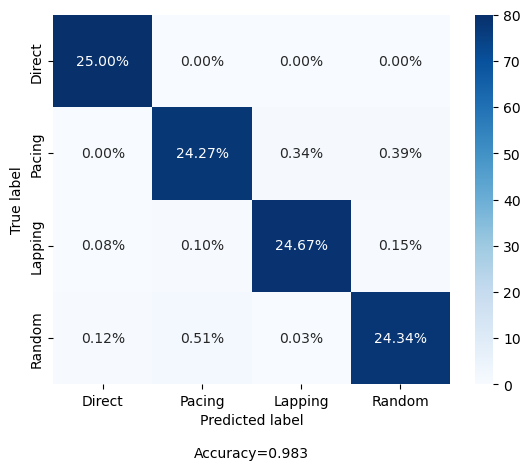

In [48]:
make_confusion_matrix(mean_of_conf_matrix_arrays, categories=labels_txt)
plt.savefig('matrix_d.pdf')